# Volatility measures MAD vs. Stdev: Taleb's thoughts + Empirical study

**TLDR: MAD (Mean absolute deviation) is a better measure of volatility for fat-tailed data**

**Outline:**
1. Many practitioners in the industry confuse volatility measures: Especially Stdev and MAD
2. Cost of mentally substituting Stdev with MAD with clear examples
3. MAD is a better measure of volatility for fat-tailed data
4. What is a statistical estimator, comparing estimators + some examples
5. Comparing MAD vs. Stdev as estimators in normal, non-normal thin-tailed, and fat-tailed data

**Summary in 6 bullet points:**
- MAD is more intuitive. It's the deviance from the mean, there is a clearer frame of reference compared to Stdev. It's also easier to remember.
- Stdev's value and its variance as an estimator skyrockets as fat-tailedness increase. This makes it less intuitive and less efficient compared to MAD.
- Stdev is a good estimator of sigma for a Gaussian world. However, many things are not Gaussian, especially stock returns.
- Sample MAD estimates population MAD better than sample Stdev estimates population sigma for fat-tailed data
- A small number of outliers is enough to create a large gap between Stdev and MAD. There are not so many outliers in Moscow Exchange data, but there's a 145% gap between Stdev and MAD.
- When talking about sigma, MAD is used in place of Stdev. This causes 25% underestimation of sigma in a Gaussian world, goes to 90% in fat tails, goes even higher to 145% in Moscow Exchange affected by the war.

## Stdev usually confused with MAD

Goldstein & Taleb show confusing volatility (sigma) with MAD may cause 25% underestimation of sigma in a Gaussian world. This number goes to 90% in fat tailed data. **Confusing these two volatility measures can be costly**

For research on how finance people confuses these measures, refer to the paper mentioned in the above sentence: "We Don't Quite Know What We are Talking About When We Talk About Volatility"

One of the reasons for the confusion is the discrepancy btwn volatility's given definition and the number on the table described as "volatility". Definition says "How much something moves every day on avg (MAD)", but the number is "Standard Deviation".

This leads to Kahneman's substitution bias: Something complex (Stdev) mentally substituted with something intuitive and easy to remember (MAD)

### Consequences of Confusing Stdev with MAD - Moscow Exchange

Let's look at Moscow Exchange index data (which shows fat tailed characteristics due to the war as of 2 Mar 2022).

Data collected from Yahoo Finance, interval is 2 Mar 2021 - 2 Mar 2022

**TL;DR: Sigma underestimated by 145% between 2 Mar 2021 - 2 Mar 2022**

For the interval between 2 Mar 2021 - 31 Dec 2021, the underestimation is 34%

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("moscow_exchange_data.csv")

In [3]:
returns = df["Adj Close"].pct_change() * 100  # in pct format

In [4]:
returns

0            NaN
1       0.174187
2      -0.540977
3       0.487698
4       1.891846
         ...    
250     1.575963
251   -33.280597
252    20.035753
253     0.000000
254     0.000000
Name: Adj Close, Length: 255, dtype: float64

In [5]:
returns = returns[~np.isnan(returns)]

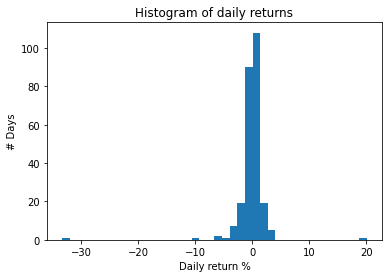

In [6]:
# hist. of daily returns
plt.hist(returns, bins=40)
plt.title("Histogram of daily returns")
plt.xlabel("Daily return %")
plt.ylabel("# Days")
plt.show()

In [7]:
mean = round(np.mean(returns), 2)
stdev = round(np.std(returns), 2)
MAD = round(np.mean(np.absolute(returns)), 2)

print(f"Mean: {mean}%  Stdev: {stdev}%  MAD: {MAD}%")
print(f"Sigma underestimated by {round((stdev - MAD) / MAD * 100, 2)}%")

Mean: -0.08%  Stdev: 2.85%  MAD: 1.16%
Sigma underestimated by 145.69%


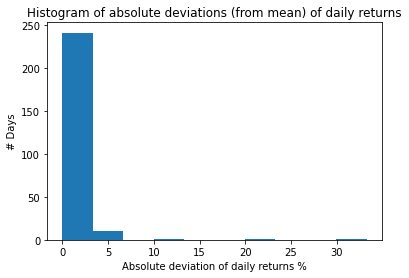

In [8]:
# hist. of deviation of daily returns from avg
returns_dev = np.absolute(returns)
plt.hist(returns_dev)
plt.title("Histogram of absolute deviations (from mean) of daily returns")
plt.xlabel("Absolute deviation of daily returns %")
plt.ylabel("# Days")
plt.show()

**Doing the above for the interval btwn 2 Mar - 31 Dec 2021**

Underestimation is 34%

In [9]:
df_2021 = df[df["Date"] <= "2021-12-31"]

returns2021 = df_2021["Adj Close"].pct_change() * 100  # in pct format
returns2021 = returns2021[~np.isnan(returns2021)]

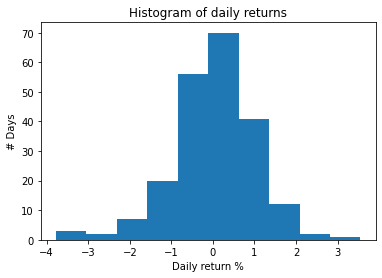

In [10]:
# hist. of daily returns
plt.hist(returns2021)
plt.title("Histogram of daily returns")
plt.xlabel("Daily return %")
plt.ylabel("# Days")
plt.show()

In [11]:
mean = round(np.mean(returns2021), 2)
stdev = round(np.std(returns2021), 2)
MAD = round(np.mean(np.absolute(returns2021)), 2)

print(f"Mean: {mean}%  Stdev: {stdev}%  MAD: {MAD}%")
print(f"Sigma underestimated by {round((stdev - MAD) / MAD * 100, 2)}%")

Mean: 0.05%  Stdev: 1.01%  MAD: 0.75%
Sigma underestimated by 34.67%


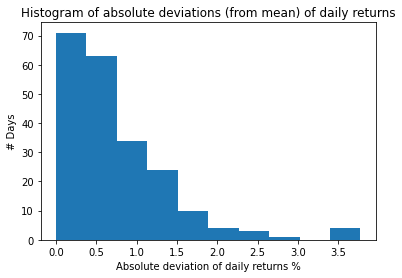

In [12]:
# hist. of deviation of daily returns from avg
returns_dev2021 = np.absolute(returns2021)
plt.hist(returns_dev2021)
plt.title("Histogram of absolute deviations (from mean) of daily returns")
plt.xlabel("Absolute deviation of daily returns %")
plt.ylabel("# Days")
plt.show()

**As the fat-tailedness increase, the difference between Stdev and MAD increase as well.**

Doing a shapiro-wilk test for "returns" and "returns2021": Both are non-normal with alpha = 0.05. **The former has W = 0.46, the latter has W = 0.97**

**Remember: the former underestimates sigma by 145%, the latter by 34%**

Approximately, W doubled, and the underestimation of sigma became 1/4 of itself

In [13]:
# doing shapiro wilk tests to returns and returns2021
# shapiro-wilk's null hypothesis = population is normally distributed
# test statistic W is "closeness to normality"
#
# let's reject H0 if pvalue <= 0.05
# remember pvalue = P(Reject H0 | Given H0 true) = Probability of a false positive

from scipy.stats import shapiro

reject = lambda pvalue: "Reject" if pvalue <= 0.05 else "Not Reject"

shapiro_returns = shapiro(returns)
shapiro_returns2021 = shapiro(returns2021)

print(round(shapiro_returns.statistic, 2), round(shapiro_returns.pvalue, 2), reject(shapiro_returns.pvalue))
print(round(shapiro_returns2021.statistic, 2), round(shapiro_returns2021.pvalue, 2), reject(shapiro_returns.pvalue))

0.46 0.0 Reject
0.97 0.0 Reject


## Why MAD a better measure of volatility

Provides a better frame of reference: Compares each point's distance to a single point(mean). More suitable for fat-tailed cases since it does not amplify fat tails. Stock returns are usually non-normal. **As fat-tailedness increases, Stdev's value and its variance as an estimator skyrockets, making it counterintuitive and sensitive to fat-tails.**

Then why Stdev exists? Because it's a better measure for describing volatility in Normal dist. Normal dist doesn't have much fat tails

Note: Sample MAD estimates population MAD a.k.a `E(|X - μ|)`. Stdev estimates σ

MAD is a better estimator under fat tails. Stdev is a better estimator in a Gaussian world. "Wdym by better?" Relative efficiency (MAD, Stdev) is > 1. A relatively efficient estimator needs less data to be an accurate estimator. This measure grows as the fat-tailedness increases:

**e(MAD, Stdev) = 0.86 in Normal dist, 1.43 in non-normal thinner tails (Returns2021), 3.87 in non-normal fat tails (Returns)**

### Short intro to estimators
An estimator is a statistic that is computed using the sample to estimate some property of a population. The sample mean (x-bar) is an estimator for the population mean (mu). Estimators are used to estimate population parameters of distributions

There can be multiple estimators for a population parameter. Such estimators are compared with two measures:
- **Consistency:** Estimator with lots of data has a distribution tightly centered around the parameter
- **Efficiency:** Minimum variance - to minimize the need for more data

"Asymptotic" means "given sufficiently large data" in this context

**Relative efficiency** helps compare two estimators wrt their variances. **The one with smaller variance requires less shots to adequately hit the target**

**Some maths about efficiency and relative efficiency**

Efficiency of an unbiased estimator T estimating parameter θ: `e(T) = 1 / (FisherInfo(θ) * Var(T))`; where `FisherInfo(θ)` is the Fisher Information of the sample (Make a notebook abt Fisher Info as well)

Relative efficiency of two estimators T1, T2: `e(T1, T2) = Var(T2) / Var(T1)`

**A case study with Poisson**

Say X ~ Pois(λ). Let λ = 5. Then E(X) = Var(X) = λ. 

E(X) and Var(X) are both estimators for λ. Which one's better?

**E(X) is relatively 11x efficient than Var(X)**

In [14]:
from scipy.stats import poisson

LAMBDA = 5

# create a poisson population of 10000 points, with λ = 5
population = poisson.rvs(mu=LAMBDA, size=10000, random_state=42)

# draw samples of size n = 100 with replacement, do it 1000 times.
sample_means = []
sample_vars = []
sample_rng = np.random.RandomState(42)
for _ in range(1000):
    sample = sample_rng.choice(population, size=100, replace=True)
    sample_means.append(round(np.mean(sample), 3))
    sample_vars.append(round(np.var(sample), 3))

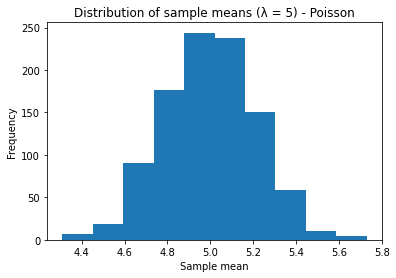

In [15]:
# distribution of sample means
plt.hist(sample_means)
plt.title(f"Distribution of sample means (λ = {LAMBDA}) - Poisson")
plt.xlabel("Sample mean")
plt.ylabel("Frequency")
plt.show()

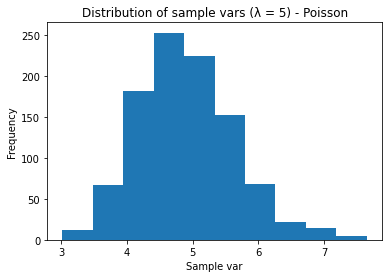

In [16]:
# distribution of sample vars
plt.hist(sample_vars)
plt.title("Distribution of sample vars (λ = 5) - Poisson")
plt.xlabel("Sample var")
plt.ylabel("Frequency")
plt.show()

In [17]:
print(f"Comparing estimators (λ = {LAMBDA}):")
print(f"Sample mean - Bias: {round(np.mean(sample_means) - LAMBDA, 3)}  Variance: {round(np.var(sample_means), 3)}")
print(f"Sample var - Bias: {round(np.mean(sample_vars) - LAMBDA, 3)}  Variance: {round(np.var(sample_vars), 3)}")

Comparing estimators (λ = 5):
Sample mean - Bias: -0.005  Variance: 0.047
Sample var - Bias: -0.097  Variance: 0.53


In [18]:
print("Comparing relative efficiencies of the two:")
print(f"Relative efficiency of Sample mean, Sample var: {round(np.var(sample_vars) / np.var(sample_means), 3)}")

Comparing relative efficiencies of the two:
Relative efficiency of Sample mean, Sample var: 11.317


Sample mean is relatively 11x efficient than the sample var as an estimator of λ

### Comparing MAD vs Stdev in Normal Dist
We said Stdev is more efficient than MAD in a Gaussian world. Let's see by looking at `e(MAD, Stdev)`

We have a Normal dist with mu = 0, sigma = 2

**Stdev is 1.16x more efficient than MAD in a Gaussian world**

In [19]:
MU = 0
SIGMA = 2

# create a gaussian population of 10000 points, with μ = 0, σ = 2
gaussian_rng = np.random.RandomState(42)
population = gaussian_rng.normal(loc=MU, scale=SIGMA, size=10000)
pop_MAD = round(np.mean(np.absolute(population)), 3)

# draw samples of size n = 100 with replacement, do it 1000 times.
sample_mads = []
sample_stdevs = []
sample_rng = np.random.RandomState(42)
for _ in range(1000):
    sample = sample_rng.choice(population, size=100, replace=True)
    sample_mads.append(round(np.mean(np.absolute(sample)), 3))
    sample_stdevs.append(round(np.std(sample), 3))

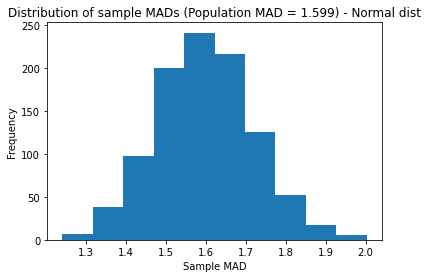

In [20]:
# distribution of sample MADs
plt.hist(sample_mads)
plt.title(f"Distribution of sample MADs (Population MAD = {pop_MAD}) - Normal dist")
plt.xlabel("Sample MAD")
plt.ylabel("Frequency")
plt.show()

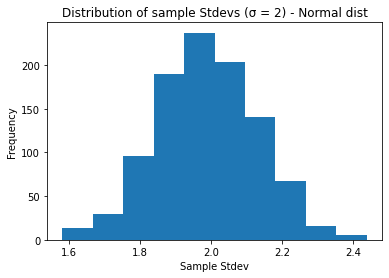

In [21]:
# distribution of sample stdevs
plt.hist(sample_stdevs)
plt.title(f"Distribution of sample Stdevs (σ = {SIGMA}) - Normal dist")
plt.xlabel("Sample Stdev")
plt.ylabel("Frequency")
plt.show()

In [22]:
print(f"Comparing estimators (σ = {SIGMA}, Population MAD = {pop_MAD}):")
print(f"Sample MAD - Bias: {round(np.mean(sample_mads) - pop_MAD, 3)}  Variance: {round(np.var(sample_mads), 3)}")
print(f"Sample Stdev - Bias: {round(np.mean(sample_stdevs) - SIGMA, 3)}  Variance: {round(np.var(sample_stdevs), 3)}")

Comparing estimators (σ = 2, Population MAD = 1.599):
Sample MAD - Bias: -0.001  Variance: 0.015
Sample Stdev - Bias: -0.012  Variance: 0.02


Comparing relative efficiency between MAD and Stdev is different than the one above. Stdev and MAD estimate different measures of volatility. Therefore instead of comparing variances, we compare their coefficients of variation.  

`e(MAD, SD) = (Var(SD ** 2) / E(SD) ** 2) / (Var(MAD) / E(MAD) ** 2)`

In [23]:
E_SD = round(np.mean(sample_stdevs), 3)
Var_SD = round(np.var(sample_stdevs), 3)

E_MAD = round(np.mean(sample_mads), 3)
Var_MAD = round(np.var(sample_mads), 3)

In [24]:
print(f"Relative efficiency of MAD, Stdev: {round((Var_SD / (E_SD ** 2)) / (Var_MAD / (E_MAD ** 2)), 3)}")

Relative efficiency of MAD, Stdev: 0.862


### Comparing MAD vs Stdev in Moscow Exchange Data

We will look at relative efficiency `e(MAD, Stdev)` in two Moscow Exchange datasets.

1. Returns: Daily returns of MOEX index btwn 2 Mar 2021 - 2 Mar 2022. **The wartime fat-tails are out and about**
2. Returns2021: Daily returns of MOEX index btwn 2 Mar 2021 - 31 Dec 2021 **Not normal by shapiro-wilk but thinner tails**

**For fat-tails, MAD is 3.87x more efficient than Stdev**

**For non-normal but thinner tails, MAD is only 1.43x more efficient than Stdev** 

(In normal dist, MAD is 0.86x less efficient than Stdev)

**Comparing MAD vs Stdev: Returns (Fat-tails)**

In [25]:
SIGMA = round(np.std(returns), 3)
pop_MAD = round(np.mean(np.absolute(returns)), 3)

# draw samples of size n = 40 with replacement, do it 400 times.
sample_mads = []
sample_stdevs = []
sample_rng = np.random.RandomState(42)
for _ in range(400):
    sample = sample_rng.choice(returns, size=40, replace=True)
    sample_mads.append(round(np.mean(np.absolute(sample)), 3))
    sample_stdevs.append(round(np.std(sample), 3))

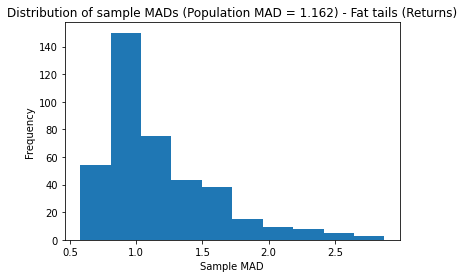

In [26]:
# distribution of sample MADs
plt.hist(sample_mads)
plt.title(f"Distribution of sample MADs (Population MAD = {pop_MAD}) - Fat tails (Returns)")
plt.xlabel("Sample MAD")
plt.ylabel("Frequency")
plt.show()

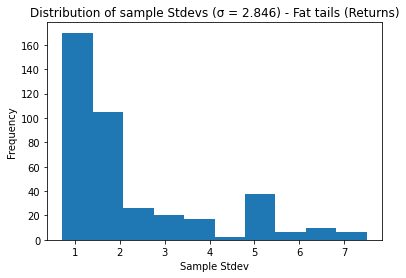

In [27]:
# distribution of sample stdevs
plt.hist(sample_stdevs)
plt.title(f"Distribution of sample Stdevs (σ = {SIGMA}) - Fat tails (Returns)")
plt.xlabel("Sample Stdev")
plt.ylabel("Frequency")
plt.show()

In [28]:
print(f"Comparing estimators (σ = {SIGMA}, Population MAD = {pop_MAD}):")
print(f"Sample MAD - Bias: {round(np.mean(sample_mads) - pop_MAD, 3)}  Variance: {round(np.var(sample_mads), 3)}")
print(f"Sample Stdev - Bias: {round(np.mean(sample_stdevs) - SIGMA, 3)}  Variance: {round(np.var(sample_stdevs), 3)}")

Comparing estimators (σ = 2.846, Population MAD = 1.162):
Sample MAD - Bias: -0.004  Variance: 0.18
Sample Stdev - Bias: -0.57  Variance: 2.692


In [29]:
E_SD = round(np.mean(sample_stdevs), 3)
Var_SD = round(np.var(sample_stdevs), 3)

E_MAD = round(np.mean(sample_mads), 3)
Var_MAD = round(np.var(sample_mads), 3)

print(f"Relative efficiency of MAD, Stdev: {round((Var_SD / (E_SD ** 2)) / (Var_MAD / (E_MAD ** 2)), 3)}")

Relative efficiency of MAD, Stdev: 3.871


**Comparing MAD vs Stdev: Returns2021 (Thinner tails)**

In [30]:
SIGMA = round(np.std(returns2021), 3)
pop_MAD = round(np.mean(np.absolute(returns2021)), 3)

# draw samples of size n = 40 with replacement, do it 400 times.
sample_mads = []
sample_stdevs = []
sample_rng = np.random.RandomState(42)
for _ in range(400):
    sample = sample_rng.choice(returns2021, size=40, replace=True)
    sample_mads.append(round(np.mean(np.absolute(sample)), 3))
    sample_stdevs.append(round(np.std(sample), 3))

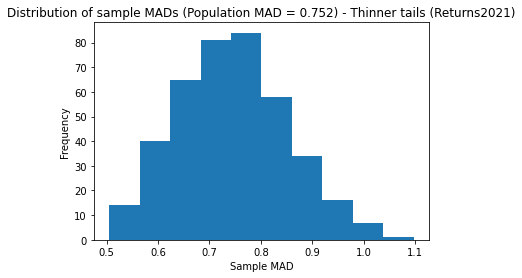

In [31]:
# distribution of sample MADs
plt.hist(sample_mads)
plt.title(f"Distribution of sample MADs (Population MAD = {pop_MAD}) - Thinner tails (Returns2021)")
plt.xlabel("Sample MAD")
plt.ylabel("Frequency")
plt.show()

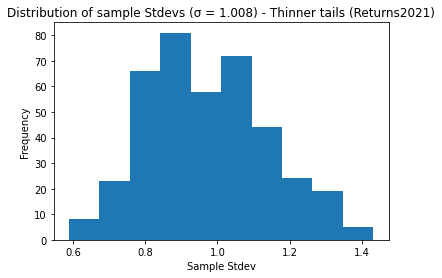

In [32]:
# distribution of sample stdevs
plt.hist(sample_stdevs)
plt.title(f"Distribution of sample Stdevs (σ = {SIGMA}) - Thinner tails (Returns2021)")
plt.xlabel("Sample Stdev")
plt.ylabel("Frequency")
plt.show()

In [33]:
print(f"Comparing estimators (σ = {SIGMA}, Population MAD = {pop_MAD}):")
print(f"Sample MAD - Bias: {round(np.mean(sample_mads) - pop_MAD, 3)}  Variance: {round(np.var(sample_mads), 3)}")
print(f"Sample Stdev - Bias: {round(np.mean(sample_stdevs) - SIGMA, 3)}  Variance: {round(np.var(sample_stdevs), 3)}")

Comparing estimators (σ = 1.008, Population MAD = 0.752):
Sample MAD - Bias: -0.008  Variance: 0.011
Sample Stdev - Bias: -0.034  Variance: 0.027


In [34]:
E_SD = round(np.mean(sample_stdevs), 3)
Var_SD = round(np.var(sample_stdevs), 3)

E_MAD = round(np.mean(sample_mads), 3)
Var_MAD = round(np.var(sample_mads), 3)

print(f"Relative efficiency of MAD, Stdev: {round((Var_SD / (E_SD ** 2)) / (Var_MAD / (E_MAD ** 2)), 3)}")

Relative efficiency of MAD, Stdev: 1.432
